<a href="https://www.kaggle.com/code/kaiyoo88/kpop-idols-embedding?scriptVersionId=204476958" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 49.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 17.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tqdm
from konlpy.tag import Okt # tokenizer for Korean
# from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model
import requests
from io import BytesIO
import pickle
import gzip

In [3]:
file_path = kagglehub.dataset_download('kaiyoo88/youtube-comments-for-top-100-ranked-kpop-idols')
file_path

'/kaggle/input/youtube-comments-for-top-100-ranked-kpop-idols'

In [4]:
train_data = pd.read_csv(f'{file_path}/youtube_comments.csv')

In [5]:
train_data.head()

,Video_ID,Artist,Comment
0,J6mQx6c0oIM,블랙핑크 제니,멋지다 한국팬들위해 엠카무대도 나오고 서있기만해도 힙하다
1,J6mQx6c0oIM,블랙핑크 제니,지금은 말할 수 있다. 솔직이 제니 도레미파솔라시 음정이 제 위치에 안꽂치고 조금씩...
2,J6mQx6c0oIM,블랙핑크 제니,김태희 얼굴이 보이는건 나뿐인가..
3,J6mQx6c0oIM,블랙핑크 제니,도대체 머라고 떠드는지... 한국에서 먼 소린지\n로제좀 본받아라
4,J6mQx6c0oIM,블랙핑크 제니,라이브 다 들려 하.. 퀸제니 진짜 미치겠다


In [6]:
print(len(train_data)) # # of comments

120101


In [13]:
# NULL check
print(train_data.isnull().values.any())
train_data = train_data.dropna(how = 'any') 
print(train_data.isnull().values.any())
print(len(train_data)) 

False
False
120101


In [14]:
# Only Korean comments were collected during data collection process.
# remove all other charcaters other than Hangeul.
train_data['Comment'] = train_data['Comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [15]:
# tokenizer for Korean comments. Use nltk or other tokenizer for English comments
okt = Okt() 

In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [17]:
tokenized_data = []
for sentence in tqdm.tqdm(train_data['Comment']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 120101/120101 [05:20<00:00, 375.23it/s]


In [7]:
# import pickle
# import gzip

# # Dump toknized_data because it takes >5 mins
# with gzip.open('tokenized_data_file.gz', 'wb') as f:
#     pickle.dump(tokenized_data, f)

# Read if tokenized_data exists
# tokenized_data_path = kagglehub.dataset_download("kaiyoo88/tokenized-data")
# with gzip.open(f'{tokenized_data_path}/tokenized_data_file', 'rb') as f:
#     tokenized_data = pickle.load(f)

# with open(f'{tokenized_data_path}/tokenized_data_file', 'rb') as f:
#     tokenized_data = pickle.load(f)

max comment length : 1070
avg comment length : 9.435816521094745


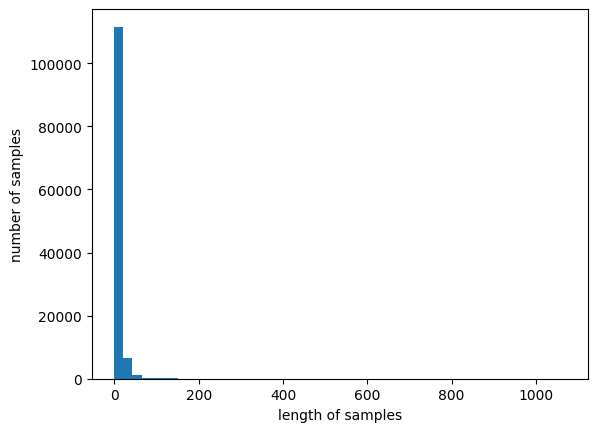

In [18]:
# Comments length distribution
print('max comment length :',max(len(comment) for comment in tokenized_data))
print('avg comment length :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(comment) for comment in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## Train Youtube comments on idols with pretrained FastText model

In [33]:
import requests
# FastText pretrained Korean embedding
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz'
response = requests.get(url)

In [18]:
import tempfile
# Write to temp_file after decompression
with gzip.GzipFile(fileobj=BytesIO(response.content)) as f:
    with tempfile.NamedTemporaryFile(delete=False) as temp_file:
        temp_file.write(f.read())
        temp_file_path = temp_file.name

In [19]:
# load model from temp_file
pre_trained_model = load_facebook_model(temp_file_path)

In [20]:
pre_trained_model.wv.vectors.shape # 100 dimension

(2000000, 300)

In [21]:
# Train on tokenized_data 
pre_trained_model.build_vocab(tokenized_data, update=True)
pre_trained_model.train(tokenized_data, total_examples=len(tokenized_data), epochs=10)

(3114336, 11332510)

In [22]:
pre_trained_model.wv.vectors.shape # 300 dimension

(2001312, 300)

In [23]:
print(pre_trained_model.wv.most_similar("웬디"))

[('아이린', 0.8893941044807434), ('공쥬', 0.8886333107948303), ('거뭐', 0.8878864049911499), ('킼', 0.8873618841171265), ('럽다', 0.8868895173072815), ('꼴다', 0.8866997957229614), ('왕귀', 0.8865935206413269), ('ㅓㅇ', 0.886573076248169), ('해바', 0.8865140676498413), ('사궈', 0.8862972855567932)]


In [24]:
print(pre_trained_model.wv.most_similar("다니엘"))

[('믕디', 0.9752152562141418), ('ㅓㅇ', 0.974928081035614), ('릴스', 0.9745247960090637), ('키범', 0.9744287133216858), ('예뽀', 0.9743986129760742), ('멋찌', 0.9743216037750244), ('진쨔', 0.9742976427078247), ('ㅠㅠㅜㅜ', 0.9741744995117188), ('녜진', 0.9741609692573547), ('얼빡', 0.9741114377975464)]


## Visualisation for Word Embedding

In [ ]:
# Generating tensor.tsv and metadata.tsv for Embedding projection.
# Generating all vocab from pretrained model will lead to creating files over 10G.
# Therefore, after training on new dataset from pretrained model, extract only vectors of tokens in my dataset from pretrained model.

In [26]:
import numpy as np
import gzip

# Extract unique token from tokenized_data
unique_words = set(word for sentence in tokenized_data for word in sentence)

# Extract vectors of tokenized_data from FastText
filtered_words = [word for word in unique_words if word in pre_trained_model.wv]
filtered_vectors = np.array([pre_trained_model.wv[word] for word in filtered_words])

# Generate tensor.tsv and metadata.tsv 
np.savetxt("tensor.tsv", filtered_vectors, delimiter='\t')

# Compress tensor.tsv because its file size is over 300MB
with open("tensor.tsv", "rb") as f_in:
    with gzip.open("tensor.tsv.gz", "wb") as f_out:
        f_out.writelines(f_in)
        
with open("metadata.tsv", "w", encoding="utf-8") as f:
    for word in filtered_words:
        f.write(f"{word}\n")

In [30]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('tensor.tsv.gz')

/kaggle/working/tensor.tsv.gz

In [ ]:
FileLink('metadata.tsv')

In [ ]:
# Embedding Visualization
# TensorFlow Embedding Projector
# Go to: https://projector.tensorflow.org/
# Load tensor.tsv and metadata.tsv 